# Convolutional Network for MNIST digits classification<sup>[1](#cite)</sup>

This notebook provides a CNN architecture composed of six convolutional layers and six max-pooling layers followed by two fully-connected layers to perform MNIST digits classification task. 

<a name="cite">1</a>: <a href="https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch
" target="_blank">this</a>
the was used as a reference to obtain the MNIST dataset and lay the base.




In [0]:
from __future__ import print_function
import time
import pickle
import gzip
import os
import urllib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [0]:
# the function to obtain dataset stats for normalization in transforms
def get_dataset_stats(dataset):

    total_mean = 0
    total_std = 0
    count = 0

    for item in dataset:
        count += 1
        total_mean += np.array(item[0][0]).mean()
        total_std  += np.array(item[0][0]).std()

    m = total_mean/count
    s = total_std/count
    
    return m, s

In [0]:

# obtain MNIST dataset and normalize the data

mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)

m,s = get_dataset_stats(mnist_train)
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                  torchvision.transforms.Normalize((m,),(s,))
                                                  ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)


In [0]:
# Create CNN model class

class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=1),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), stride=[2,2], padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=1),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=1),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
  
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(2, 2), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        # fc layers
        self.lin = nn.Linear(512*2*2,100)
        self.clf = nn.Linear(100, 10)

    def forward(self, x):
        return self.clf(self.lin(self.conv(x).view(-1,512*2*2)))
    
        

In [5]:

# create classifier instance
clf = Classifier()

cuda_available = torch.cuda.is_available()
print ('cuda availability: {}'.format(cuda_available))
if cuda_available:
    clf = clf.cuda()

# SGD with a learning rate of 0.1, without regularization using cross-entropy loss
optimizer = optim.SGD(clf.parameters(), lr = 0.01, weight_decay=0)
criterion = nn.CrossEntropyLoss()

cuda availability: True


In [6]:

print(clf)

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=[2, 2], padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1

In [7]:
params_count = sum(p.numel() for p in clf.parameters())
print('total number of parameters: {}'.format(params_count))


total number of parameters: 967382


In [8]:
num_epochs = 10

epoch_losses = {}
epoch_losses['train'] = []
epoch_losses['test'] = []

epoch_accuracy = {}
epoch_accuracy['train'] = []
epoch_accuracy['test'] = []


for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    
    # Training
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs)
        
        # get loss and backpropagate it through the network
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    clf.eval()
    
    # Evaluation test
    test_total = 0
    test_correct = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = clf(inputs)
        
        # iteration accuracy
        _, predicted = torch.max(outputs.data, 1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets.data).cpu().sum()
        
        # iteration loss
        test_loss = criterion(outputs, targets)
        test_losses.append(np.float(test_loss.data))
        

    epoch_losses['test'].append(np.mean(test_losses))

    test_acc = 100* np.float(test_correct)/np.float(test_total)
    print('Epoch : %d Test Acc : %.3f' % (epoch, test_acc))
    epoch_accuracy['test'].append(test_acc)
        
    
    # Evaluate train
    train_correct = 0
    train_total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs)
        
        # iteration accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets.data).cpu().sum()
        
        # iteration loss
        train_loss = criterion(outputs, targets)
        train_losses.append(np.float(train_loss.data))

    
    print('Epoch : %d Train Loss : %.3f ' % (epoch, np.mean(train_losses)))
    epoch_losses['train'].append(np.mean(train_losses))
    
    train_acc = 100* np.float(train_correct)/np.float(train_total)
    epoch_accuracy['train'].append(train_acc)
        
    print('--------------------------------------------------------------')
    
    clf.train()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch : 0 Test Acc : 64.010
Epoch : 0 Train Loss : 1.090 
--------------------------------------------------------------
Epoch : 1 Test Acc : 95.500
Epoch : 1 Train Loss : 0.155 
--------------------------------------------------------------
Epoch : 2 Test Acc : 97.520
Epoch : 2 Train Loss : 0.089 
--------------------------------------------------------------
Epoch : 3 Test Acc : 98.530
Epoch : 3 Train Loss : 0.055 
--------------------------------------------------------------
Epoch : 4 Test Acc : 98.360
Epoch : 4 Train Loss : 0.060 
--------------------------------------------------------------
Epoch : 5 Test Acc : 98.560
Epoch : 5 Train Loss : 0.045 
--------------------------------------------------------------
Epoch : 6 Test Acc : 98.170
Epoch : 6 Train Loss : 0.066 
--------------------------------------------------------------
Epoch : 7 Test Acc : 98.890
Epoch : 7 Train Loss : 0.033 
--------------------------------------------------------------
Epoch : 8 Test Acc : 98.790
Epoc

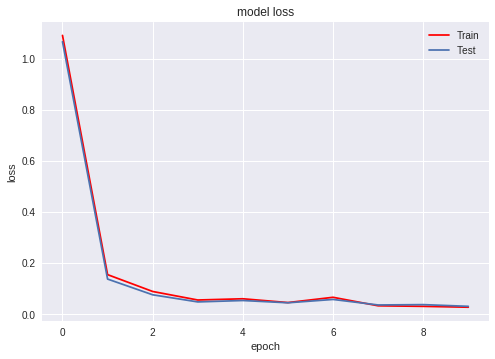

In [13]:
# plot Train versus Test loss
fig = plt.figure()

plt.plot(epoch_losses['train'], 'r')
plt.plot(epoch_losses['test'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])

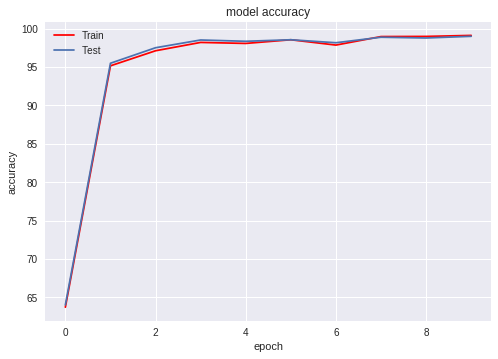

In [14]:
# plot Train versus Test accuracy
fig = plt.figure()

plt.plot(epoch_accuracy['train'], 'r')
plt.plot(epoch_accuracy['test'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])